In [71]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [72]:
plt.rcParams['figure.dpi'] = 150

In [73]:
alphabet = np.arange(-(8-1),8,2)
#alphabet = np.array([-10, -6, -3, -1, 1, 3, 6, 10]) <-- Non-uniform alphabet
alphabet = alphabet / np.sqrt(np.mean(alphabet**2))

class Receiver(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M)

    def forward(self, y):
        y = self.lin1(y)
        return y

class Encoder(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M, bias=False)
        nn.init.constant_(self.lin1.weight, 1 / M)
        self.out = nn.Softmax(dim=0)

    def forward(self, y):
        return self.out(self.lin1(y))

class Mapper(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(M, 1)
        self.lin1.weight = nn.Parameter(torch.Tensor([[i for i in alphabet]])) # set weigths equal to alphabet

    def forward(self, y):
        y = self.lin1(y)
        return y

In [74]:
def sampler(prob, n):
    samples = torch.empty(0)
    for idx, p in enumerate(prob):
        occurrences = torch.round(n * p).type(torch.LongTensor)
        samples = torch.cat((samples, torch.ones(occurrences, dtype=torch.int64) * torch.tensor(idx)))
    indexes = torch.randperm(samples.shape[0])
    return samples[indexes]

def gradient_correction_factor(app, idx, prob, M):
    (nn,M)= app.shape
    cf  = torch.zeros(M)
    for j in range(M):
        tmp = app[:, j]
        cf[j] = torch.sum(torch.log(tmp[idx==j])) / (nn*prob[j]) # tmp[idx==j] selects the ll of those xy pairs which belong to the current symbol j
    return cf

In [75]:
def AWGN_channel(x, sigma2):
    noise_t = np.sqrt(sigma2)*torch.randn(x.shape)
    return x + noise_t

In [76]:
M = 8
n = 10_000
SNR_dB = 5
SNR = 10**(SNR_dB/10)
sigma2 = 1/SNR
nepochs = 4000

dec = Receiver(M)
enc = Encoder(M)
mapper = Mapper(M)
loss_fn = nn.CrossEntropyLoss()

alphabet = np.arange(-(M-1),M,2)
# alphabet = np.array([-10, -6, -3, -1, 1, 3, 6, 10]) <-- Non-uniform alphabet
alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
alphabet_t = torch.tensor(alphabet).float()

In [77]:
alphabet_t.shape

torch.Size([8])

In [78]:
for i in range(0, M):
    i_onehot = nn.functional.one_hot(torch.tensor(i), 8).float()
    print(mapper(i_onehot))

tensor([-1.3247], grad_fn=<AddBackward0>)
tensor([-0.8883], grad_fn=<AddBackward0>)
tensor([-0.4518], grad_fn=<AddBackward0>)
tensor([-0.0154], grad_fn=<AddBackward0>)
tensor([0.4210], grad_fn=<AddBackward0>)
tensor([0.8575], grad_fn=<AddBackward0>)
tensor([1.2939], grad_fn=<AddBackward0>)
tensor([1.7303], grad_fn=<AddBackward0>)


In [79]:
enc.lin1._parameters['weight'].shape

torch.Size([8, 1])

In [80]:
lr = 0.01
opt = optim.Adam( list(enc.parameters()) + list(dec.parameters()) + list(mapper.parameters()), lr=lr)
# opt = optim.Adam( list(enc.parameters()) + list(dec.parameters()), lr=lr)


In [81]:
torch.arange(1,M+1).squeeze()

tensor([1, 2, 3, 4, 5, 6, 7, 8])

In [82]:
mapper(nn.functional.one_hot(torch.arange(M),M).float()).squeeze().shape

torch.Size([8])

In [83]:
for j in range(nepochs):
    # logits = enc(torch.tensor([1], dtype=torch.float))
    probs = enc(torch.tensor([1], dtype=torch.float))
    # probs =  nn.functional.softmax(logits, -1)
    probs.retain_grad()

    # Sample indexes
    indices = sampler(probs, n)
    indices = indices.type(torch.LongTensor)

    # Modulation
    alphabet_t = mapper(nn.functional.one_hot(torch.arange(M),M).float()).squeeze()
    norm_factor = torch.rsqrt(torch.sum(torch.pow(torch.abs(alphabet_t), 2) * probs))
    alphabet_norm =  alphabet_t * norm_factor 
    onehot = nn.functional.one_hot(indices, M).float()
    symbols = torch.matmul(onehot, torch.transpose(input=alphabet_norm.reshape(1,-1), dim0=0, dim1=1))
    
    # Channel
    y = AWGN_channel(symbols, sigma2) 

    # Demodulator
    ll = dec(y.reshape(-1,1).float())
    app = nn.functional.softmax(ll, 1) #Q(X|Y)

    # Loss
    loss = -(torch.sum(-probs*torch.log(probs)) - loss_fn(ll, indices))# -(H(X) - CE(P,Q)), the gradient descent minimizes, therefore we minimize the opposite to maximize the MI in the end.
    opt.zero_grad()
    loss.backward(retain_graph=True)


    # correction factor
    cf = - (gradient_correction_factor(app, indices, probs, M) - torch.log(probs)).detach()

    # if j % 500 == 0:
    #     print('missing factors: ', cf.detach().numpy())
    #     print('current grad: ', probs.grad.detach().numpy())

    probs.grad = cf
    probs.backward(torch.tensor([1., 1., 1., 1., 1., 1., 1., 1.]))

    # probs.grad += cf.detach()
    # enc.lin1._parameters['weight'].grad += cf.reshape(-1, 1).detach()

    
    opt.step()

    # Printout and visualization
    if j % 500 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() / np.log(2) :.4f}')

epoch 0: Loss = 0.2860
epoch 500: Loss = -1.0027
epoch 1000: Loss = -1.0229
epoch 1500: Loss = -1.0287
epoch 2000: Loss = -1.0152
epoch 2500: Loss = -1.0377
epoch 3000: Loss = -1.0232
epoch 3500: Loss = -1.0251


In [84]:
enc.lin1._parameters['weight']

Parameter containing:
tensor([[ 0.8607],
        [-1.2975],
        [ 0.0489],
        [ 0.8545],
        [ 0.6036],
        [-1.5188],
        [ 0.5780],
        [-0.0152]], requires_grad=True)

In [85]:
probs

tensor([0.2186, 0.0251, 0.0964, 0.2173, 0.1682, 0.0201, 0.1635, 0.0908],
       grad_fn=<SoftmaxBackward0>)

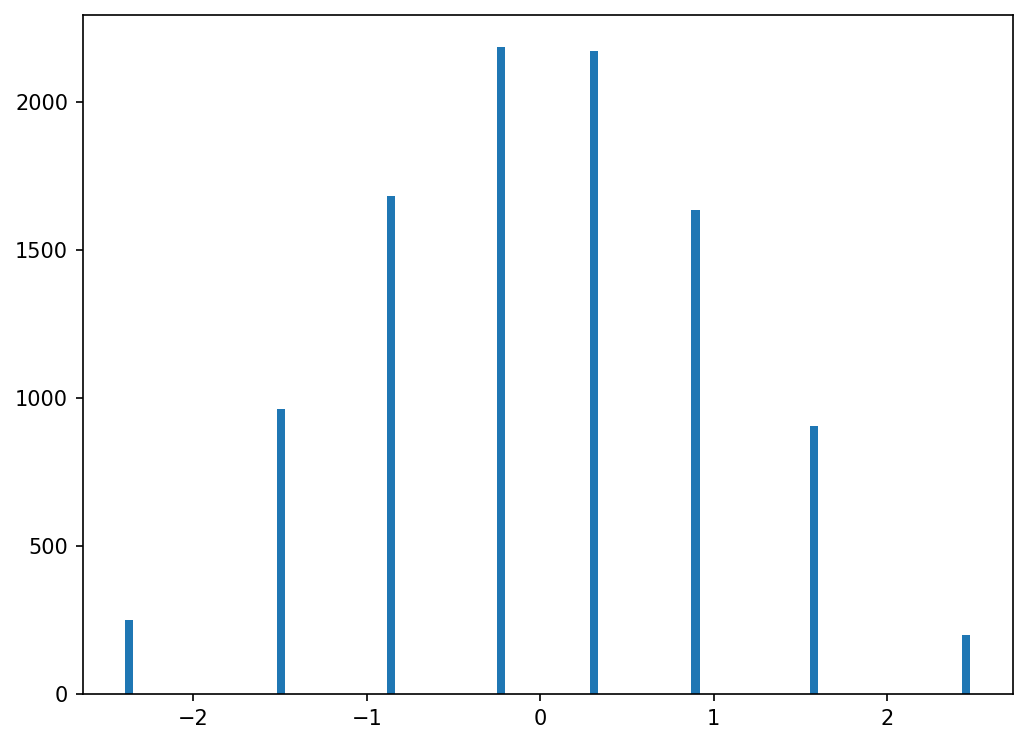

In [86]:
plt.hist(symbols.detach().numpy(), bins=100)
plt.show()

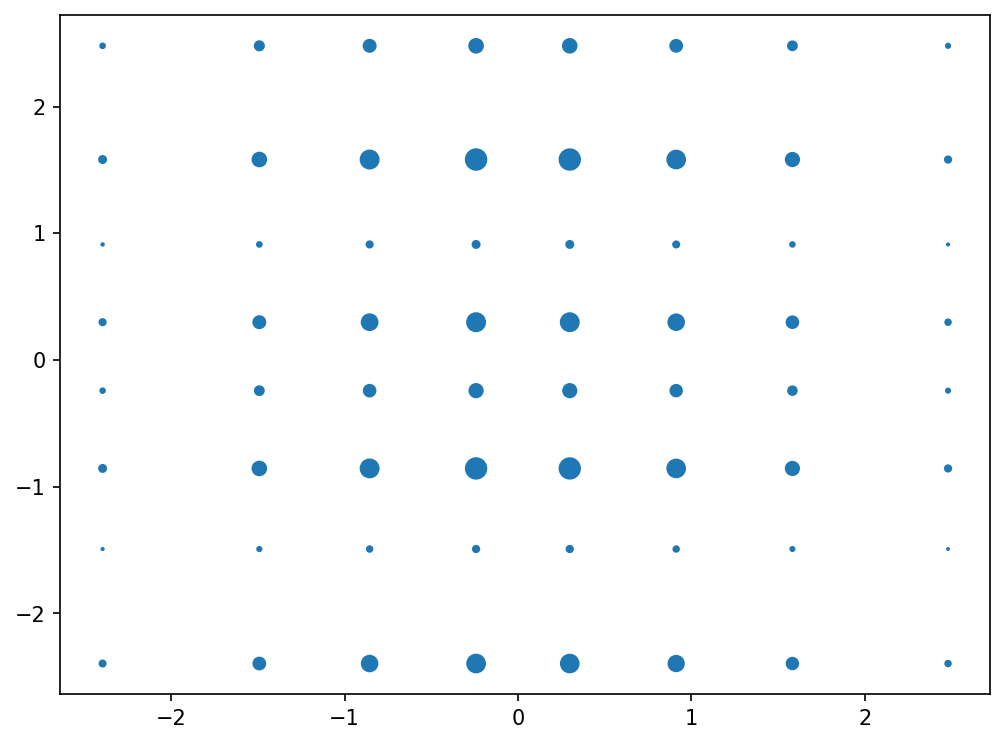

In [87]:
# Scatterplot
pp = (probs.reshape(-1,1)*probs.reshape(1,-1)).reshape(-1,1).detach().numpy()
alph = alphabet_norm.detach().numpy()
a = []
for c in np.flip(alph):
    for d in alph:
        a.append(d+1j*c)
plt.scatter(np.real(a), np.imag(a), pp*2000)   
plt.show()

### Compare Results

In [88]:
def AWGN_channel_np(x, sigma2):
    noise = np.sqrt(sigma2) * np.random.randn(x.size)
    return x + noise

In [89]:
def AWGNdemapper(y, const, varN):
    apps = np.exp(-np.abs(np.transpose([y])-const)**2/(2*varN))
    return apps / np.transpose([np.sum(apps, 1)])

In [90]:
def xesmd(apps, idx):
    """
    Estimates symbolwise equivocation from reference symbols indices and a posteriori probabilities.
    """
    eq = -np.log(np.take_along_axis(apps, idx[:, None], axis=1) / np.transpose([np.sum(apps, 1)]))
    eq[eq==np.inf] = 1000
    return np.mean(eq)

In [91]:
n = 100_000
SNR_dBs = np.arange(5,22)
M = 8
alphabet = np.arange(-7,8,2)
alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
indices = np.random.choice(np.arange(M), n)
symbols = alphabet[indices]

mi_64 = []
for snrdB in SNR_dBs:
    sigma2 = 1/(10**(snrdB/10))
    sigma2 = sigma2 
    y = AWGN_channel_np(symbols, sigma2)
    apps = AWGNdemapper(y, alphabet, sigma2)
    xe = xesmd(apps, indices)
    mi_64.append(2*(3 - (xe) / np.log(2)))

In [92]:
print((-2*loss.detach()/np.log(2)).detach().numpy())

2.0849774


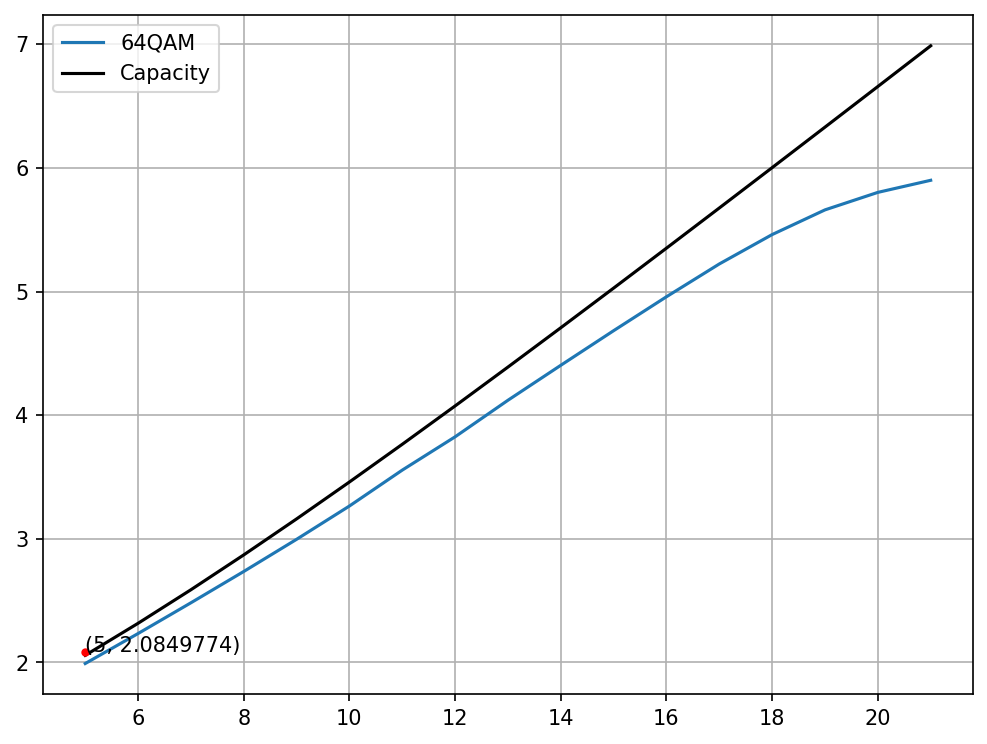

In [93]:
# Plot
plt.rcParams['figure.figsize'] = [8, 6]
plt.plot(SNR_dBs, mi_64, label = '64QAM')
plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)), color='black', label='Capacity')

plt.plot(SNR_dB, -2*loss.detach()/np.log(2), color='red', marker='o', markersize=3)
xy = (SNR_dB, (-2*loss.detach()/np.log(2)).detach().numpy())
plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.legend()
plt.grid()

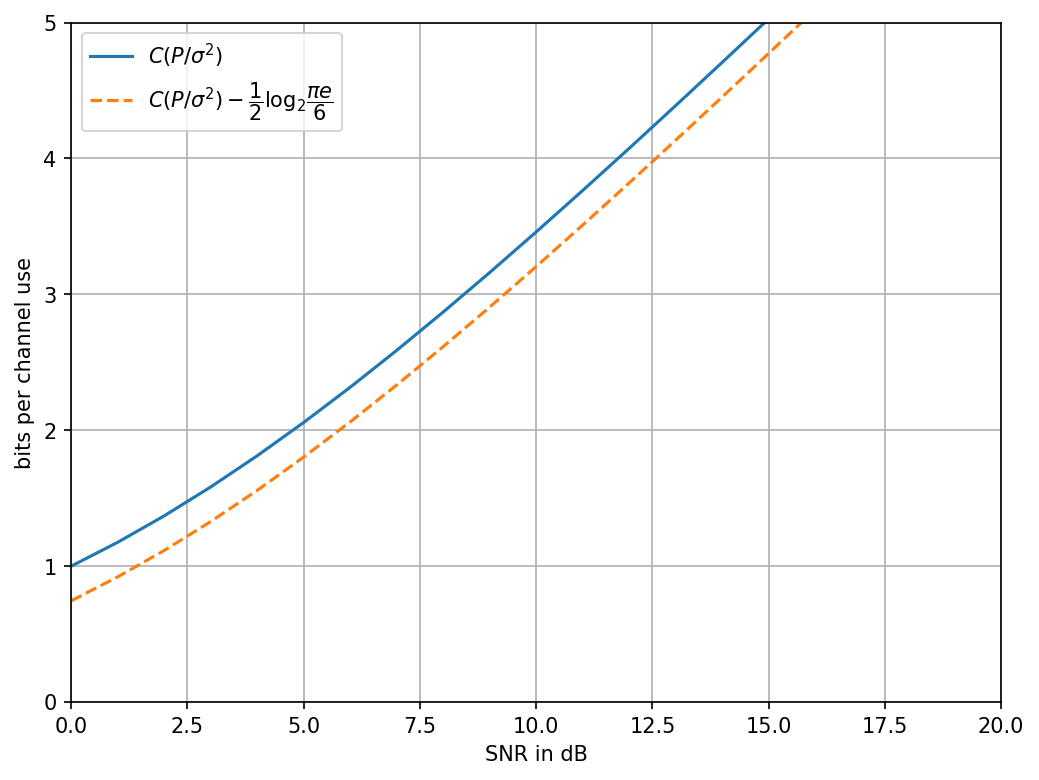

In [94]:
SNR_dBs = np.arange(0,20)
plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)), color='C0', label='$C(P/\sigma^2)$')
plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)) - 0.5*np.log2((np.pi*np.e)/6) , linestyle='dashed', color='C1', label='$C(P/\sigma^2) - \dfrac{1}{2}\log_2\dfrac{\pi e}{6}$')
plt.grid()
plt.ylabel('bits per channel use')
plt.xlabel('SNR in dB')
plt.xlim([0, 20])
plt.ylim([0, 5])
# plt.title('AWGN channel capacity gap')
plt.legend()